## Visualize example images with annotations

In [1]:
%matplotlib inline
from pycocotools.coco import COCO
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2 as cv2
#Set your DATASET DIR
DATASET_DIR = '../smartex_acquisition_ws/smartex_textile/'


In [2]:
coco=COCO(os.path.join(DATASET_DIR,'labels/smartex_annotations_cocostyle.json'))
print(coco.getImgIds())

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122]


[{'id': 2, 'width': 821, 'height': 320, 'file_name': '096cab534c_stack.png', 'license': 0, 'flickr_url': 'jumper boardeux tezenis', 'coco_url': '', 'date_captured': '2025-09-08T08:51:19Z'}]
(320, 821, 252)


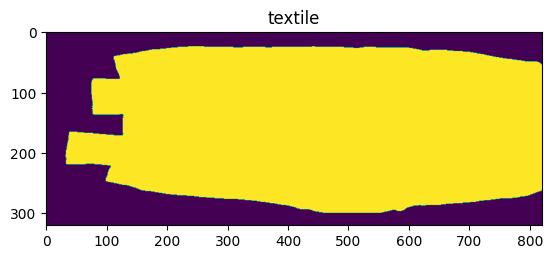

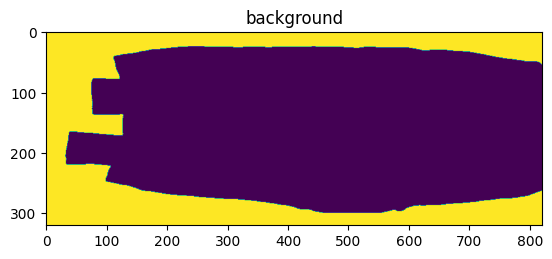

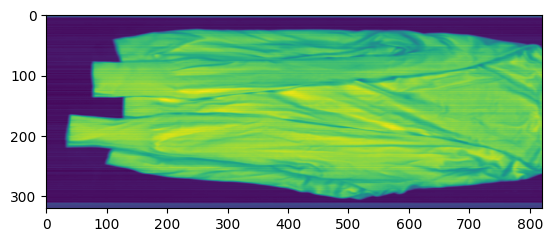

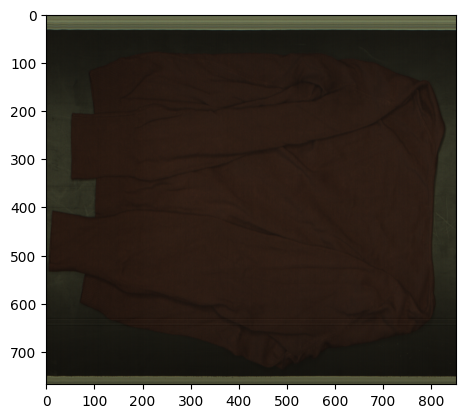

In [3]:
img_id =2
img = coco.loadImgs(img_id)
print(img)
file_name = img[0]['file_name'].split('.')[0].split('_')[0]
annIds = coco.getAnnIds(imgIds=img_id, catIds=[1,2,3], iscrowd=None)
anns = coco.loadAnns(annIds)
non_textile = [ann for ann in anns if ann['category_id']==3]
if(len(non_textile)>0):
    mask_nontextile = coco.annToMask(non_textile[0])
    plt.imshow(mask_nontextile)
    plt.title('non-textile')
    plt.figure()
ann_textile = [ann for ann in anns if ann['category_id']==2][0]
mask = coco.annToMask(ann_textile)
plt.imshow(mask)
plt.title('textile')
plt.figure()


ann_background = [ann for ann in anns if ann['category_id']==1][0]
mask = coco.annToMask(ann_background)
plt.imshow(mask)
plt.title('background')

plt.figure()
cube = np.load(os.path.join(DATASET_DIR,'data/hsi/%s.npy'%file_name))
plt.imshow(cube[:,:,120])
print(cube.shape)
plt.figure()
rgb = cv2.imread(os.path.join(DATASET_DIR,'data/rgb/%s.png'%file_name))

plt.imshow(cv2.cvtColor(rgb,cv2.COLOR_BGR2RGB))


## Statistics
This block calculates some statistics about the materials present in the dataset

🧵 Total pure material entries: 61


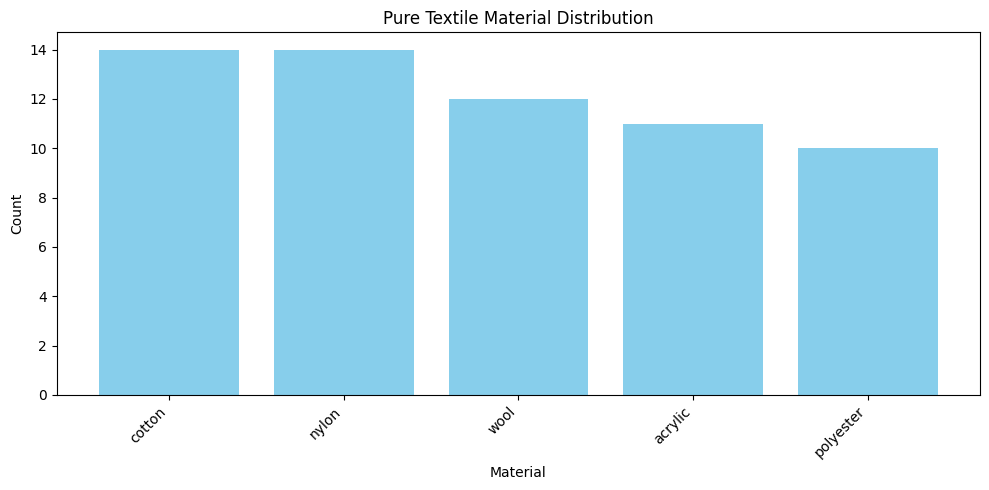

🧵 Total composite entries: 59


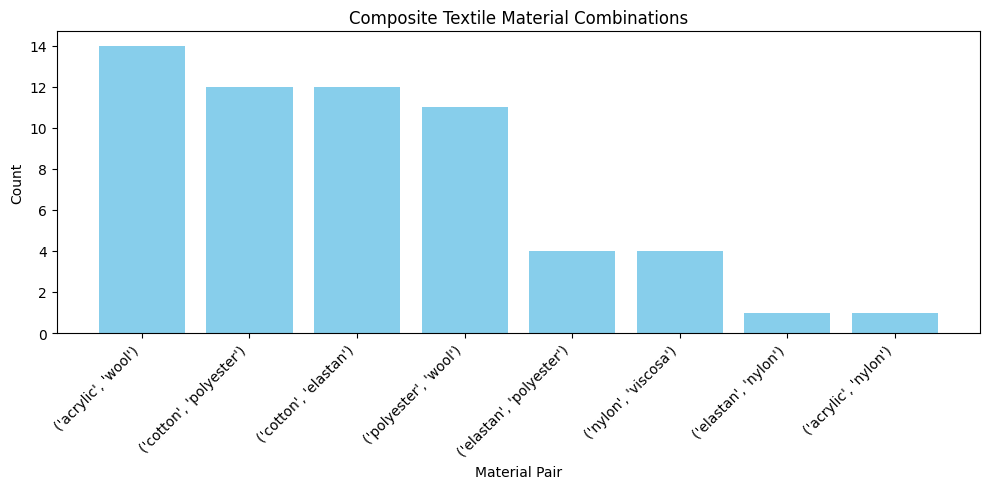

🧩 Number of unique images with non-textile elements: 17


In [4]:


import json
from collections import Counter
import matplotlib.pyplot as plt


def load_coco_annotations(path):
    with open(path, 'r') as f:
        return json.load(f)


def extract_textile_materials(coco_data):
    textile_cat_ids = {cat['id'] for cat in coco_data['categories'] if cat['name'] == 'textile'}
    textile_annotations = [ann for ann in coco_data['annotations'] if ann['category_id'] in textile_cat_ids]
    
    material_counts = Counter()
    composite_counts = Counter()
    
    for ann in textile_annotations:
        
        
        materials = ann.get("attributes", {})
        materials = {k: v for k, v in materials.items() if v > 0}
        
        if len(materials) == 1:
            mat = list(materials.keys())[0]
            material_counts[mat] += 1
        elif len(materials) == 2:
            key = tuple(sorted(materials.keys()))
            composite_counts[key] += 1
        
    
    return material_counts, composite_counts


def count_non_textile_elements(coco_data):
    non_textile_cat_ids = {cat['id'] for cat in coco_data['categories'] if cat['name'] == 'non-textile'}
    non_textile_annotations = [ann for ann in coco_data['annotations'] if ann['category_id'] in non_textile_cat_ids]

    image_ids = {ann["image_id"] for ann in non_textile_annotations}
    return len(image_ids)


def plot_bar_chart(counter, title, xlabel, ylabel, rotation=45):
    keys = list(counter.keys())
    values = [counter[k] for k in keys]

    plt.figure(figsize=(10, 5))
    plt.bar(range(len(keys)), values,color='skyblue',)
    plt.xticks(range(len(keys)), [str(k) for k in keys], rotation=rotation, ha='right')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.tight_layout()
    plt.savefig(f"{title}.png")
    plt.show()


# Main function for Jupyter use
annotation_path = os.path.join(DATASET_DIR,'labels/smartex_annotations_cocostyle.json')
coco_data = load_coco_annotations(annotation_path)

pure_counts, composite_counts = extract_textile_materials(coco_data)
non_textile_count = count_non_textile_elements(coco_data)
pure_sorted = {k: v for k, v in sorted(pure_counts.items(), key=lambda item: item[1],reverse=True)}
non_textile_count_sorted = {k: v for k, v in sorted(composite_counts.items(), key=lambda item: item[1],reverse=True)}
print(f"🧵 Total pure material entries: {sum(pure_sorted.values())}")
plot_bar_chart(pure_sorted, "Pure Textile Material Distribution", "Material", "Count")

print(f"🧵 Total composite entries: {sum(non_textile_count_sorted.values())}")
plot_bar_chart(non_textile_count_sorted, "Composite Textile Material Combinations", "Material Pair", "Count")

print(f"🧩 Number of unique images with non-textile elements: {non_textile_count}")


🧵 Total pure material entries: 48


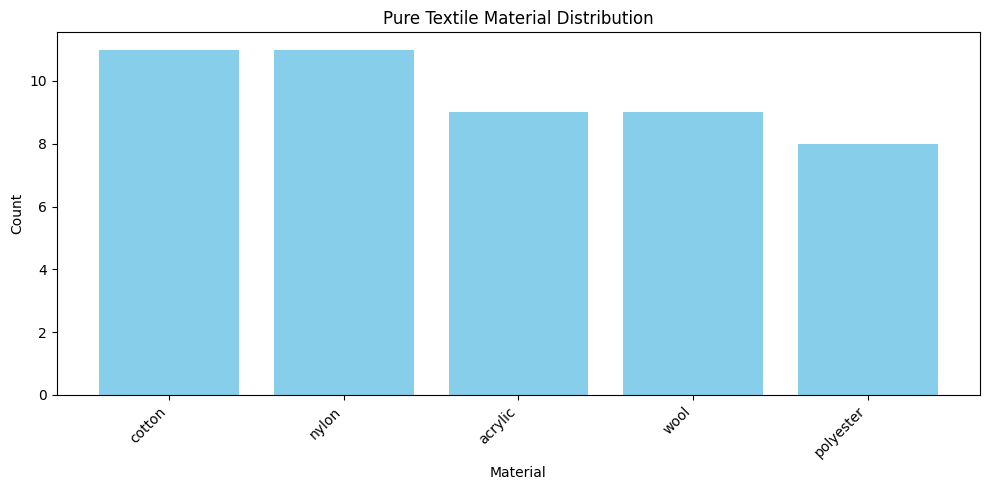

🧵 Total composite entries: 46


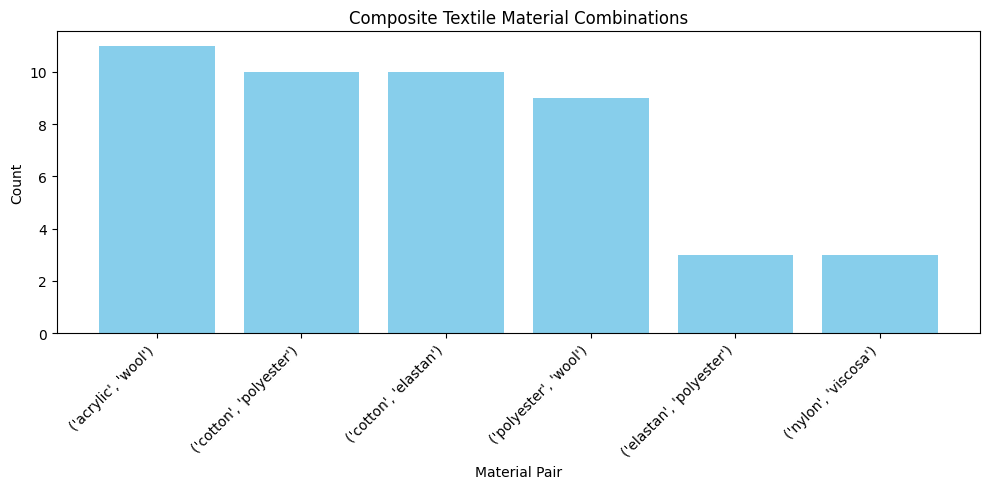

🧩 Number of unique images with non-textile elements: 12


In [11]:

coco_data = load_coco_annotations(annotation_path)

#filter annoations only of images with id in a file
train_list = []
with open('train.txt','r') as f:
    train_list = f.read().splitlines()

coco_data['images'] = [img for img in coco_data['images'] if img['file_name'].split('.')[0].split('_')[0] in train_list]
coco_data['annotations'] = [ann for ann in coco_data['annotations'] if ann['image_id'] in [img['id'] for img in coco_data['images']]]
pure_counts, composite_counts = extract_textile_materials(coco_data)
non_textile_count = count_non_textile_elements(coco_data)
pure_sorted = {k: v for k, v in sorted(pure_counts.items(), key=lambda item: item[1],reverse=True)}
non_textile_count_sorted = {k: v for k, v in sorted(composite_counts.items(), key=lambda item: item[1],reverse=True)}
print(f"🧵 Total pure material entries: {sum(pure_sorted.values())}")
plot_bar_chart(pure_sorted, "Pure Textile Material Distribution", "Material", "Count")

print(f"🧵 Total composite entries: {sum(non_textile_count_sorted.values())}")
plot_bar_chart(non_textile_count_sorted, "Composite Textile Material Combinations", "Material Pair", "Count")

print(f"🧩 Number of unique images with non-textile elements: {non_textile_count}")


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


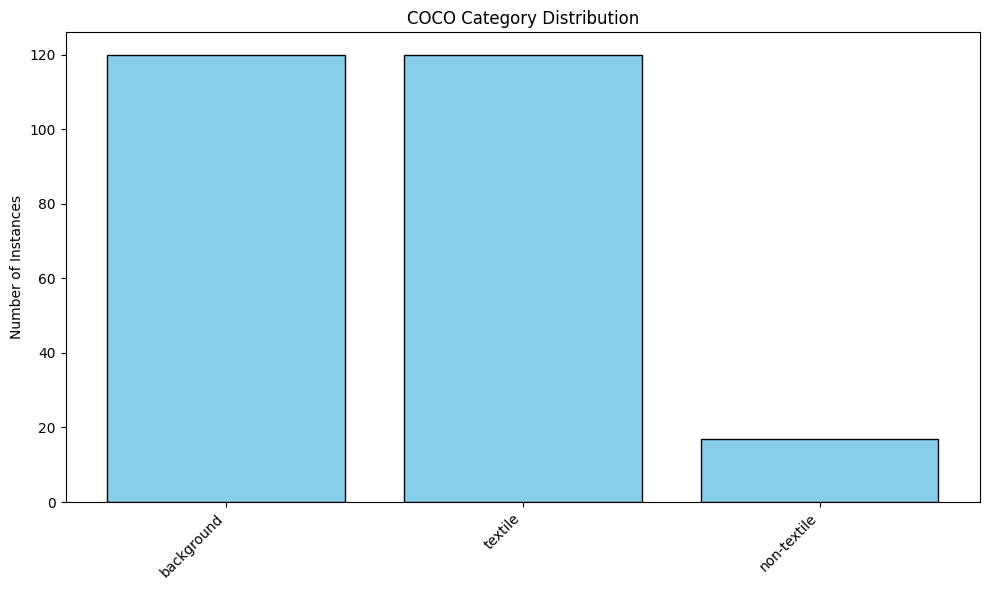

,Category,Count
0,background,120
1,textile,120
2,non-textile,17


In [6]:
import json
import matplotlib.pyplot as plt
import pandas as pd
from collections import Counter
from pycocotools.coco import COCO

def plot_coco_category_distribution(coco_json_path):
    """
    Load a COCO-format JSON file and plot the distribution of categories.

    Parameters
    ----------
    coco_json_path : str
        Path to the COCO annotation JSON file.
    """
    # Load COCO annotations
    coco = COCO(coco_json_path)

    # Build mapping id -> name
    cat_id_to_name = {cat['id']: cat['name'] for cat in coco.loadCats(coco.getCatIds())}

    # Collect category ids from annotations
    ann_ids = coco.getAnnIds()
    anns = coco.loadAnns(ann_ids)
    cat_ids = [ann['category_id'] for ann in anns]

    # Count frequencies
    counts = Counter(cat_ids)

    # Map ids to names
    cat_names = [cat_id_to_name[cid] for cid in counts.keys()]
    frequencies = [counts[cid] for cid in counts.keys()]

    # Create dataframe for ordering
    df = pd.DataFrame({'Category': cat_names, 'Count': frequencies})
    df = df.sort_values('Count', ascending=False)

    # Plot
    plt.figure(figsize=(10,6))
    plt.bar(df['Category'], df['Count'], color='skyblue', edgecolor='black')
    plt.xticks(rotation=45, ha='right')
    plt.ylabel("Number of Instances")
    plt.title("COCO Category Distribution")
    plt.tight_layout()
    plt.savefig('cat_distr.png')
    plt.show()
    
    return df
plot_coco_category_distribution(os.path.join(DATASET_DIR,'labels/smartex_annotations_cocostyle.json'))

In [7]:
def draw_composition_distribution_with_tolerance(df, mat1, mat2, tolerance=10):
    """
    Draw a bar chart showing distribution of compositions between mat1 and mat2.
    Categories are deterministic in this order:
      1. Majority mat1: mat1 > 50 + tolerance
      2. Balanced (~50/50): within tolerance around 50%
      3. Majority mat2: mat2 > 50 + tolerance

    Parameters
    ----------
    df : pandas.DataFrame
        DataFrame containing a column 'composition' with composition dicts.
    mat1, mat2 : str
        Names of the two materials to filter on.
    tolerance : int or float
        Allowed deviation from 50% to be considered "balanced".
    """

    # Filter rows that have exactly the two materials
    def valid_composition(comp):
        return isinstance(comp, dict) and set(comp.keys()) == {mat1, mat2}

    filtered = df[df['composition'].apply(valid_composition)].copy()

    if filtered.empty:
        print("No rows found with exactly the two specified materials.")
        return None

    # Normalize compositions to sum to 100
    def normalize(comp):
        total = sum(comp.values())
        return {k: v / total * 100 for k, v in comp.items()}

    filtered['composition'] = filtered['composition'].apply(normalize)

    # Extract mat1 percentage
    mat1_perc = filtered['composition'].apply(lambda x: x[mat1])

    # Categorize deterministically
    categories = []
    for val in mat1_perc:
        if val >= 50 + tolerance:
            categories.append(f"Majority {mat1}")
        elif val <= 50 - tolerance:
            categories.append(f"Majority {mat2}")
        else:
            categories.append("Balanced (~50/50)")

    # Count with fixed order
    ordered_labels = [f"Majority {mat1}", "Balanced (~50/50)", f"Majority {mat2}"]
    counts = pd.Series(categories).value_counts().reindex(ordered_labels, fill_value=0)

    # Plot
    plt.figure(figsize=(6,5))
    counts.plot(kind='bar', color='skyblue', edgecolor='black')
    plt.ylabel("Count")
    plt.title(f"Distribution of {mat1} vs {mat2}")
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.savefig(f"{mat1}_{mat2}.png")
    plt.show()

    return counts

📊 Frequency of composition types:


composition_label
cotton                 14
nylon                  14
cotton+polyester       12
cotton+elastan         12
acrylic+wool           12
polyester+wool         12
wool                   11
acrylic                11
polyester              10
nylon+viscosa           4
elastan+polyester       4
elastan+nylon           1
acrylic+nylon           1
acrlyic+alpaca+wool     1
acrylic+alpaca+wool     1
Name: count, dtype: int64


📊 Frequency of individual materials:


cotton       38
polyester    38
wool         37
acrylic      25
nylon        20
elastan      17
viscosa       4
alpaca        2
acrlyic       1
dtype: int64

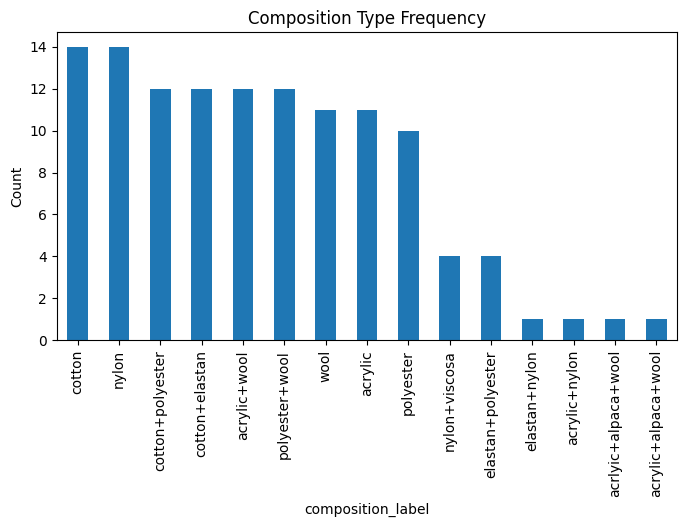

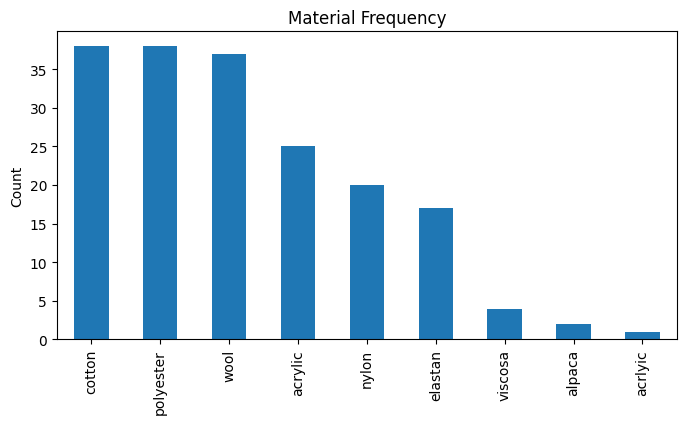

In [8]:
import json
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

# ---- Config ----
jsonl_path = "../smartex_acquisition_ws/smartex_textile/labels/smartex_dataset_compositions.jsonl"  # <-- change to your file path

# ---- Load data ----
records = []
with open(jsonl_path, "r") as f:
    for line in f:
        records.append(json.loads(line))

df = pd.DataFrame(records)

# ---- Extract composition ----
# Build a normalized representation of material combinations
def normalize_composition(comp):
    # Keep only materials with >0 percentage
    present = [m.lower() for m, v in comp.items() if v > 0]
    return "+".join(sorted(present))

df["composition_label"] = df["composition"].apply(normalize_composition)

# ---- Statistics ----
# 1. Frequency of composition types (pure cotton, cotton+elastan, etc.)
composition_counts = df["composition_label"].value_counts()

# 2. Frequency of individual materials
all_materials = []
for comp in df["composition"]:
    all_materials.extend([m.lower() for m, v in comp.items() if v > 0])

material_counts = Counter(all_materials)

# ---- Display ----
print("📊 Frequency of composition types:")
display(composition_counts)

print("\n📊 Frequency of individual materials:")
display(pd.Series(material_counts).sort_values(ascending=False))

# ---- Plots ----
composition_counts.plot(kind="bar", figsize=(8,4), title="Composition Type Frequency")
plt.ylabel("Count")
plt.show()

pd.Series(material_counts).sort_values(ascending=False).plot(
    kind="bar", figsize=(8,4), title="Material Frequency"
)
plt.ylabel("Count")
plt.show()

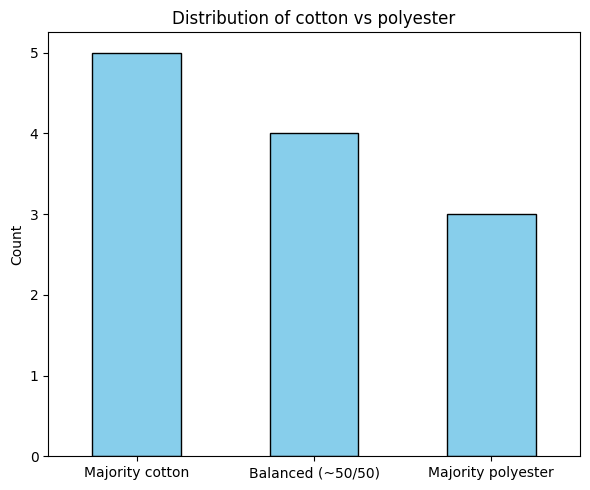

Majority cotton       5
Balanced (~50/50)     4
Majority polyester    3
Name: count, dtype: int64

In [9]:
draw_composition_distribution_with_tolerance(df,'cotton','polyester',tolerance=15)